<a href="https://colab.research.google.com/github/AYA-NASH/NN_with_TensorFlow/blob/main/7_Milestone_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check the GPU type to see if it's compute capabilities is 7.0+
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-250ea513-a1ef-1202-7c08-54978f480456)


In [ ]:
import tensorflow as tf

In [ ]:
tf.test.gpu_device_name(),tf.__version__


('/device:GPU:0', '2.11.0')

In [ ]:
# a workaround to fix the mixed percision problem with tensorflow version 2.5+
# Downgrade Tensorflow Version (run this in Google Colab) 
!pip install tensorflow==2.4.1

In [ ]:
import tensorflow as tf
tf.__version__

'2.11.0'

####Getting Helper functions:

In [ ]:
import os

if not os.path.exists("helper_functions.py"):
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
      print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

####Load Food101 tensorflow data set

In [ ]:
import tensorflow_datasets as tfds

# path = "/content/drive/MyDrive/NN_with_TensorFlow"
# Construct a tf.data.Dataset
(train_data, test_data), ds_info = tfds.load(name = 'food101',
                                              split=['train','validation'],
                                              shuffle_files=True,
                                              as_supervised = True,
                                              with_info = True)
                                              # data_dir = path)
                                              # download = True)

# Build your input pipeline
# ds = ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
# for example in ds.take(1):
#   image, label = example["image"], example["label"]

In [ ]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
original_train_data = train_data
original_test_data = test_data

exploring image Tensors :
  class_names,
  shape,
  dtype,
  label type (one-hot encoded or an integer).

In [ ]:
# 1- extracting a list of class names
class_names = ds_info.features['label'].names

# class_names[:10]

In [ ]:
# 2- getting the shape of image-tensors
# extracting one sample of our data
training_one_sample = train_data.take(1);

training_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in training_one_sample:
 print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 49
  Class name (str form): grilled_cheese_sandwich
        


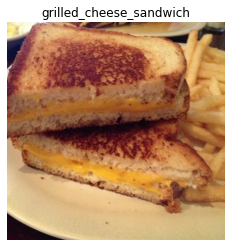

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])

plt.axis(False);

####Preprocessing Food101 image-Tensors [those are from TFDS]

the current tensors have:
*   different shapes [use `tf.image.resize`]
*   uint8 type (is should be float32) [use `tf.cast`]
*   not scaled (ranged 0-255, required: 0-1) [not required in efficientnet]






In [ ]:
#in:image_tensor -> out: preprocessed image.
def preprocess_img(image, label, image_size = 224):
  #reshaping:
  image = tf.image.resize(image, [image_size, image_size])
  # uint8 -> float32
  return tf.cast(image, dtype=tf.float32), label

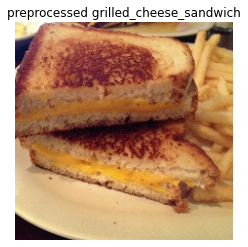

In [ ]:
preprocessd_img = preprocess_img(image,label)

plt.imshow(preprocessd_img[0]/255)
plt.title('preprocessed '+class_names[label.numpy()])
plt.axis(False);

####Batch & Prepare dataset

In [ ]:
#1- mapping the preprocess_image function to all data set images and in parallel
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
#2- shuffle-convert to batches-prefetch:
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Same steps for test set , note: don't shuffle test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

####Create Modeling Callbacks

tensorboard & checkpoint callbacks.

In [ ]:
# tensorboard callback exists in the helper_functions.py
checkpoint_path =  "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = 'val_acc',
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 0)

####Mixed Precision training:

In [ ]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy(policy = "mixed_float16")

In [ ]:
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

####Building Feature Extraction Model with Mixed Precision:

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# mixed precision training is turned on above (by set_global_policy () method)
# define the base model:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)


In [ ]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), # Use sparse_categorical_crossentropy when labels are *not* one-hot
              #  loss_weights=[1.0,alpha.numpy()],
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

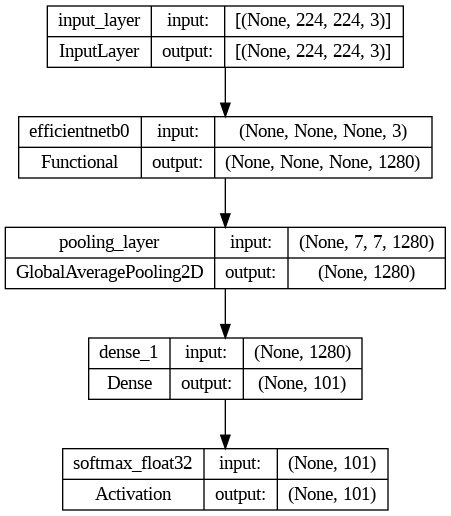

In [ ]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# check the same above details for our base model (the 2nd layer which is the efficientnetb0):

for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float


Fit the feature extraction model

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

history =  model.fit(train_data, 
                    epochs=3,  
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[create_tensorboard_callback("training_logs", 
                                                          "efficientnetb0_101_classes_all_data_feature_extract"),
                              model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230215-073816
Epoch 1/3
2368/2368 [==============================] - 209s 84ms/step - loss: 1.7166 - accuracy: 0.5821 - val_loss: 1.1234 - val_accuracy: 0.7007
Epoch 2/3
2368/2368 [==============================] - 201s 84ms/step - loss: 1.1986 - accuracy: 0.6896 - val_loss: 1.0351 - val_accuracy: 0.7124
Epoch 3/3
2368/2368 [==============================] - 220s 92ms/step - loss: 1.0537 - accuracy: 0.7250 - val_loss: 0.9964 - val_accuracy: 0.7275


Evaluating the feature extraction model:

In [ ]:
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 59s 74ms/step - loss: 0.9979 - accuracy: 0.7288


####Saving the whole model:

In [ ]:
# save_to_path = "/content/Food101_feature_extraction_model"
# model.save(save_to_path)
# saved_model_path = '/tmp/tf_save'
# tf.saved_model.save(model, saved_model_path)
keras_model_path = '/tmp/Food101_feature_extraction_model'
model.save(keras_model_path)

In [ ]:
# Load model previously saved above
# loaded_model = tf.keras.models.load_model(saved_model_path)

DEFAULT_FUNCTION_KEY = 'serving_default'
loaded_model = tf.saved_model.load(saved_model_path)
inference_func = loaded_model.signatures[DEFAULT_FUNCTION_KEY]

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
# for layer in loaded_model.layers:
#   print(layer.name)

(<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7efbded8cf40>,
 <ConcreteFunction signature_wrapper(*, input_layer) at 0x7EFBD26E43D0>)

In [ ]:
\

####Preparing our model's layers for fine-tuning

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2023-02-15 08:13:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 74.125.128.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  15.1MB/s    in 1.1s    

2023-02-15 08:14:01 (15.1 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# Load and evaluate downloaded GS model
gs_loaded_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
gs_loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
gs_loaded_model_results = gs_loaded_model.evaluate(test_data)

790/790 [==============================] - 66s 79ms/step - loss: 1.0881 - accuracy: 0.7066


In [ ]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
gs_loaded_model.trainable = True
print("UNFREEZED MODEL:\n")
for layer in gs_loaded_model.layers[1].layers[:10]:
  print(layer.name, layer.trainable)

UNFREEZED MODEL:

input_1 True
rescaling True
normalization True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True


In [ ]:
# Check to see what dtype_policy of the layers in your loaded model are
for layer in gs_loaded_model.layers:
  print(layer.name, layer.dtype_policy)

input_layer <Policy "float32">
efficientnetb0 <Policy "mixed_float16">
pooling_layer <Policy "mixed_float16">
dense <Policy "mixed_float16">
softmax_float32 <Policy "float32">


In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
# YOUR_CODE_HERE
EarlyStopping_callback = EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being further defined as "for at least 3 epochs"
        patience=3
    )

# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
# YOUR_CODE_HERE


finetune_checkpoint_path =  "finetuning_model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension

fine_tuning_checkpoint_callback =  ModelCheckpoint(finetune_checkpoint_path,
                                                      monitor = 'val_loss',
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 0)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              min_lr=1e-7)

In [ ]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
# YOUR_CODE_HERE
gs_loaded_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
# YOUR_CODE_HERE

tf.get_logger().setLevel('ERROR')

fine_tuning_history =  gs_loaded_model.fit(train_data, 
                                  epochs=100,
                                 steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=int(0.15 * len(test_data)),
                                  initial_epoch = history.epoch[-1],
                                  callbacks=[create_tensorboard_callback("training_logs", 
                                                                        "efficientnetb0_101_classes_all_data_fine_tuning"),
                                  fine_tuning_checkpoint_callback,
                                  EarlyStopping_callback])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_fine_tuning/20230215-095345
Epoch 3/100
2368/2368 [==============================] - 463s 173ms/step - loss: 0.9262 - accuracy: 0.7504 - val_loss: 0.8018 - val_accuracy: 0.7820
Epoch 4/100
2368/2368 [==============================] - 417s 175ms/step - loss: 0.5793 - accuracy: 0.8410 - val_loss: 0.8111 - val_accuracy: 0.7839
Epoch 5/100
2368/2368 [==============================] - 768s 323ms/step - loss: 0.3313 - accuracy: 0.9057 - val_loss: 0.8590 - val_accuracy: 0.7826
Epoch 6/100
2368/2368 [==============================] - 414s 174ms/step - loss: 0.1734 - accuracy: 0.9486 - val_loss: 0.9634 - val_accuracy: 0.7873


In [ ]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
gs_loaded_model.save('/content/drive/MyDrive/tensorflow_course/Food101_fine_tuning')

In [ ]:
# Evaluate mixed precision trained fine-tuned model 
gs_loaded_model.evaluate(test_data)

790/790 [==============================] - 59s 74ms/step - loss: 0.9811 - accuracy: 0.7825


[0.9810668230056763, 0.7824950218200684]

####View training results on TensorBoard

In [ ]:
# Upload experiment results to TensorBoard (uncomment to run)
# !tensorboard dev upload --logdir ./training_logs \
#   --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
#   --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
#   --one_shot

####Evaluate your trained model

In [ ]:
predicted_probabilities = gs_loaded_model.predict(test_data)
predicted_classes = predicted_probabilities.argmax(axis=1)


790/790 [==============================] - 67s 80ms/step


In [ ]:
# Unbatch the test set and pull out the true-labels:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, predicted_classes)
sklearn_accuracy

0.006653465346534653